In [215]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import datasets

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.expand_frame_repr = False

In [209]:
""" Берём необходимые колонки """
data = pd.read_csv('loans.csv', sep=',', low_memory=False)
data = data.drop(["id", "funded_amount", "activity", "use", "country", "region", "currency", "partner_id",
                  "posted_time", "disbursed_time", "funded_time", "tags", "date"], axis=1)
#data.to_csv('my_loans.csv', sep=',', index=False)
print(data.head(10))
new_data = data.copy()

   loan_amount          sector country_code  term_in_months  lender_count borrower_genders repayment_interval       salary
0        300.0            Food           PK            12.0            12                F          irregular  7804.960599
1        575.0  Transportation           PK            11.0            14                F          irregular  8923.815853
2        150.0  Transportation           IN            43.0             6                F             bullet  4211.587293
3        200.0            Arts           PK            11.0             8                F          irregular  2620.228720
4        400.0            Food           PK            14.0            16                F            monthly  6194.828276
5        250.0        Services           KE             4.0             6                F          irregular  3935.015285
6        200.0     Agriculture           IN            43.0             8                F             bullet  4793.081082
7        400.0  

In [210]:
""" Подготавливаем данные для обработки """
def detect_gender(sex):
    if 'M' == sex:
        return 1
    else:
        return 0


def detect_repayment(repayment):
    if repayment == 'irregular':
        return 0
    else:
        return 1


# Подготавливаем данные
data.dropna(inplace=True)

# Encoding пол
data["borrower_genders"] = data["borrower_genders"].apply(lambda x: detect_gender(str(x))).astype('bool')
unique_gender = data["borrower_genders"].unique()
# Encoding по типу платежей
unique_repayment_interval = data["repayment_interval"].unique()
data["repayment_interval"] = data["repayment_interval"].apply(lambda x: detect_repayment(str(x))).astype('bool')
# Encoding цели на которые был взят кредит
unique_sector = list(data["sector"].unique())
risk_estimate = [random.randint(1, 10) for _ in range(len(unique_sector))]
data["sector"] = data["sector"].apply(lambda x: risk_estimate[unique_sector.index(x)]).astype('int8')
# Encoding по расовому признаку
unique_country = list(data["country_code"].unique())
country_index = [i for i in range(1, len(unique_country) + 1)]
data["country_code"] = data["country_code"].apply(lambda x: country_index[unique_country.index(x)]).astype('int8')

# Нормализуем некатегориальные переменные
scaler = PowerTransformer()
norm_columns = ["loan_amount", "term_in_months", "lender_count", "salary"]
data[norm_columns] = scaler.fit_transform(data[norm_columns])
# data["lender_count"] = data["lender_count"].apply(lambda x: -x)

# Убираем выбросы
data[norm_columns] = data[(data[norm_columns] > data[norm_columns].quantile(0.10)) & (data[norm_columns] < data[norm_columns].quantile(0.90))][norm_columns]
data.dropna(inplace=True)

#data.to_csv('your_loans.csv', sep=',', index=False)
print(data.head(10))

    loan_amount  sector  country_code  term_in_months  lender_count  borrower_genders  repayment_interval    salary
0     -0.562350       3             1        0.048887     -0.078668             False               False  1.180546
3     -1.054342       4             1       -0.139306     -0.474521             False               False -0.596585
4     -0.229640       3             1        0.371824      0.210583             False                True  0.745400
7     -0.229640       1             1        0.371824     -0.474521             False                True  0.807156
8     -0.037163       8             1        0.371824      0.386007             False                True -1.104913
9      0.260769       3             1       -0.139306      0.627106             False               False  0.270693
12    -0.229640       7             1        0.371824      0.210583             False                True  0.753668
13    -0.229640       6             1        0.048887     -0.258592     

D:\PythonEnv\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


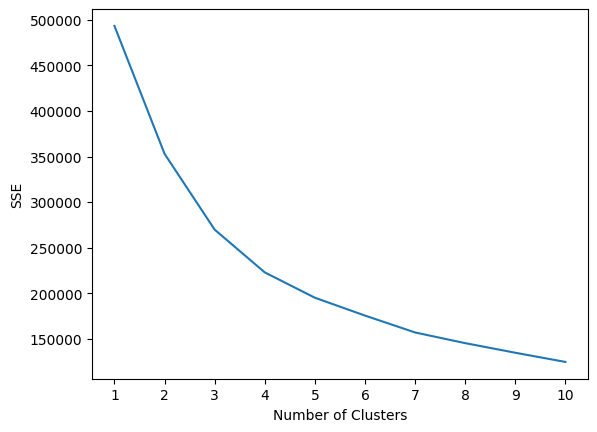

In [211]:
""" Смотрим динамику кол-ва групп """
X = (data[norm_columns][::]).values
#X = data.values

kmeans_kwargs = {"init": "k-means++", "n_init": 4, "max_iter": 300, "random_state": 42, "algorithm": "elkan"}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")   # SSE - это сумма квадратов расстояний между каждой точкой и ее ближайшим центром кластеров.
plt.show()

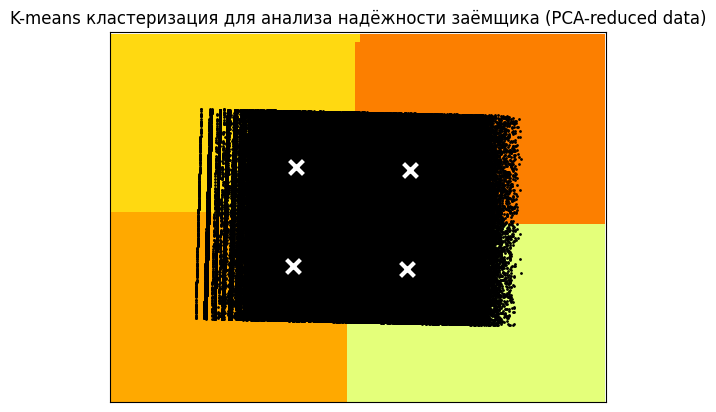

In [212]:
""" Пытаемся представить результат в графическом виде на плоскости """
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.05  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Wistia,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=100,
    linewidths=3,
    color="white",
    zorder=10,
)
plt.title(
    "K-means кластеризация для анализа надёжности заёмщика (PCA-reduced data)"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [213]:
""" Подводим итоги """
new_data = new_data.loc[data.index.tolist()]
new_data["cluster_index"] = kmeans.fit_predict(X)

def group_info(group):
    total_count = len(group)
    female_count = len(group[group["borrower_genders"] == 'F'])
    male_count = len(group[group["borrower_genders"] == 'M'])
    female_ratio = female_count / total_count * 100
    male_ratio = male_count / total_count * 100

    p = group[["loan_amount", "term_in_months",  "lender_count", "salary"]].mean()
    country = group["country_code"].value_counts()
    sector = group["sector"].value_counts()
    print("This is {} cluster:\n{}".format(0, pd.concat([country[:3], sector[:3]])))
    return pd.Series({"group_count": total_count,
                      "female %": female_ratio,
                      'male %': male_ratio,
                      "loan_amount": p[0],
                      "term_in_months": p[1],
                      "lender_count": p[2],
                      "salary": p[3],
                      "country": country.idxmax(),
                      "sector": sector.idxmax()})

result = new_data.groupby("cluster_index").apply(group_info)
print(result)


# Оцениваем точность кластеризации с помощью метрики силуэта
# silhouette_avg = silhouette_score(X, kmeans.labels_, metric='euclidean') = 0.24660796399652274

# Оцениваем точность кластеризации с помощью индекса Калински-Харабаш
print("Метрика силуэта := 0.24660796399652274")
print("Индекс Калински-Харабаш := {}".format(calinski_harabasz_score(X, kmeans.labels_)))
print("K-means score := {}".format(kmeans.score(X)))

This is 0 cluster:
KE              9166
SV              8777
PH              6429
Agriculture    24919
Food           14319
Retail         12631
Name: count, dtype: int64
This is 0 cluster:
KE              8168
SV              7795
PH              5681
Agriculture    22587
Food           12972
Retail         11308
Name: count, dtype: int64
This is 0 cluster:
PH             31282
KE             13104
PK              6003
Agriculture    21312
Food           18441
Retail         17953
Name: count, dtype: int64
This is 0 cluster:
PH             29003
KE             12470
PK              5934
Agriculture    20541
Food           17281
Retail         16757
Name: count, dtype: int64
               group_count   female %     male %  loan_amount  term_in_months  lender_count       salary country       sector
cluster_index                                                                                                                
0                    80556  72.868563  27.131437   793.284175   

In [216]:
"""# создаем данные для обучения
data = pd.read_csv('loans.csv', sep=',', low_memory=False)

def group_info(group):
    loan_amount = group[["loan_amount"]].mean()

X_train = data.groupby("date").apply(group_info)
y_train = [[100], [150], [200], [250], [300]]

# создаем полиномиальные признаки степени 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# обучаем линейную регрессию на полиномиальных признаках
model = LinearRegression()
model.fit(X_train_poly, y_train)

# предсказываем цену на недвижимость для новых данных
X_test = [[6], [7], [8]]
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)
print(y_pred)"""

[[350.]
 [400.]
 [450.]]
